In [4]:
'''В данной программе объединены обучение и предсказание на автоэнкодере LSTM.
Отличие от CNN в проектировании: для обучения производится преобразование множества коэффициентов аномальности
к распределнному значению со средним 0 и стандартным отклонением 1, на малых коэффициентах отклонение
не будет слишком высоким и будет варьироваться от [-1;1] или в окрестности крайних точек.
Когда то же распределение применяется к аномальным данным, получается, что отклонение будет сильно превышать
значение самой дальней точки.
Подготовка данных будет включать в себя разделение на множество X и множество Y для обучающего и тестового наборов.
В множестве X находятся вектора со значениями коэффициентов, каждый вектор имеет длину 15, каждому такому вектору соответсвует
число из множества Y, которое будет являться ожидаемым продолжением последовательности.
После обучения на данных с низким коэффициентом аномальности, средняя абсолютная ошибка для нормальных
данных составила 0.3, это значение было принято за порог нормы.
Далее были повторены все те же самые операции и для тестового датасета, после чего по нему был сделан предикт.
В результате получилось, что средняя абсолютная ошибка для всех аномальных записей превысила порог в несколько раз.
Результат работы представлен в таком виде для иллюстративности работы программы.'''
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Input, Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Model
import seaborn as sns

In [5]:
dataframe = pd.read_csv('B:\Учёба\диплом\трафик\For_lstm.csv')

In [7]:
df = dataframe[['time', 'expect']]

In [8]:
df['time'] = pd.DataFrame(df['time'])

<ipython-input-8-868b21c5d106>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = pd.DataFrame(df['time'])


In [11]:
train, test = df.loc[:10000,:], df.loc[52000:,:]

scaler = StandardScaler()
scaler = scaler.fit(train[['expect']])

train['expect'] = scaler.transform(train[['expect']])
test['expect'] = scaler.transform(test[['expect']])

In [18]:
seq_size = 15 

def to_sequences(x, y, seq_size=1):
    x_values = []
    y_values = []

    for i in range(len(x)-seq_size):
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])
        
    return np.array(x_values), np.array(y_values)

trainX, trainY = to_sequences(train[['expect']], train['expect'], seq_size)
testX, testY = to_sequences(test[['expect']], test['expect'], seq_size)

In [21]:
model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(trainX.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(trainX.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 15, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 15, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

In [22]:
history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/10
281/281 [==============================] - 19s 43ms/step - loss: 0.5209 - val_loss: 0.3333
Epoch 2/10
281/281 [==============================] - 11s 38ms/step - loss: 0.3453 - val_loss: 0.3259
Epoch 3/10
281/281 [==============================] - 11s 38ms/step - loss: 0.3284 - val_loss: 0.3240
Epoch 4/10
281/281 [==============================] - 11s 38ms/step - loss: 0.3227 - val_loss: 0.3069
Epoch 5/10
281/281 [==============================] - 11s 38ms/step - loss: 0.3228 - val_loss: 0.3152
Epoch 6/10
281/281 [==============================] - 11s 38ms/step - loss: 0.3212 - val_loss: 0.3259
Epoch 7/10
281/281 [==============================] - 11s 38ms/step - loss: 0.3289 - val_loss: 0.3278
Epoch 8/10
281/281 [==============================] - 11s 38ms/step - loss: 0.3267 - val_loss: 0.3332
Epoch 9/10
281/281 [==============================] - 11s 39ms/step - loss: 0.3270 - val_loss: 0.3272
Epoch 10/10
281/281 [==============================] - 11s 38ms/step - loss: 0.314

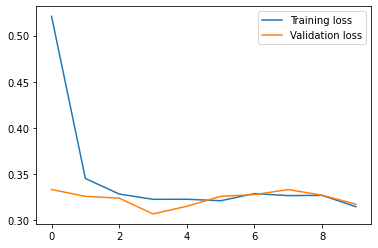

In [23]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

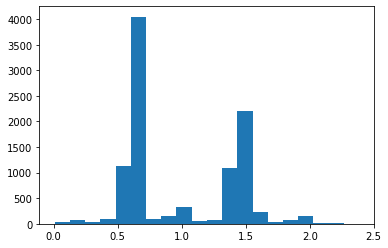

In [24]:
trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict - trainX), axis=1)
plt.hist(trainMAE, bins=20)
max_trainMAE = 0.3

(array([ 31.,  12., 103.,  96.,  96., 154., 175., 179., 219., 218., 298.,
        157., 138., 109.,  75.,  44.,  57.,  23.,  27.,  25.,  15.,  19.,
         12.,  11.,  13.,   0.,   1.,   1.,   1.,   2.]),
 array([15.54068606, 15.78088177, 16.02107748, 16.26127319, 16.5014689 ,
        16.74166461, 16.98186032, 17.22205603, 17.46225174, 17.70244745,
        17.94264316, 18.18283887, 18.42303458, 18.66323029, 18.903426  ,
        19.1436217 , 19.38381741, 19.62401312, 19.86420883, 20.10440454,
        20.34460025, 20.58479596, 20.82499167, 21.06518738, 21.30538309,
        21.5455788 , 21.78577451, 22.02597022, 22.26616593, 22.50636164,
        22.74655734]),
 <BarContainer object of 30 artists>)

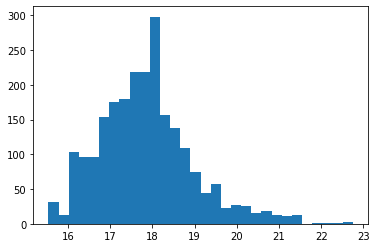

In [27]:
testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict - testX), axis=1)
plt.hist(testMAE, bins=30)

In [28]:
anomaly_df = pd.DataFrame(test[seq_size:])
anomaly_df['testMAE'] = testMAE
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']
anomaly_df['expect'] = test[seq_size:]['expect']
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]

In [32]:
anomalies.to_csv('B:\Учёба\диплом\трафик\After_lstm.csv')